In [111]:
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as sln
from scipy import sparse


Solve the 1D heat equation using FDM for a conductive rod.
Fixed mesh size and time step size. 

Dirichlet boundary conditions: homogeneous constant (zero).

$\frac{\partial u}{\partial t} = \kappa\frac{\partial^2 u}{\partial x^2}$

Which we discretize with (at least) forward Euler in time, and second order central difference in space.

Denote index $i$ subscript for steps in space, $\delta$ superscript for steps in time.

$\frac{\partial u}{\partial t} \approx \frac{1}{\Delta t}(u_i ^{(\delta + 1)}- u_i ^{(\delta)})$ is the forward difference in time.

$\frac{\partial^2 u}{\partial x^2} \approx \frac{1}{h^2}(u_{i+1} ^{(\delta)} + u_{i-1} ^{(\delta)} - 2u_{i} ^{(\delta)}))$ is the second order central difference in x.



In [112]:
L = 10             #length of the rod
p = 101             #no. of interior points + 2 boundary points

h = L/(p-1)        #mesh size
print(L, p, h)

10 101 0.1


The system can be expressed as matrix multiplication.
du/dt = Ku + b

The matrix form of the one-dimensional Laplacian is the Toeplitz matrix, whose number of elements depends on the size of the grid. 

Here, there are p-2 interior grid points and 2 boundary points, so the dimensions are $(p-2)\times(p-2)$

In [113]:
#set up the system.
#method 1. dense matrix: 
#K = ln.toeplitz(np.append(np.array([-2, 1]),np.zeros(p-4)))


#method 2. sparse matrix:

K = sparse.diags(
    [1,-2,1],
    [-1,0,1],
    shape = (p-2, p-2)
)

kappa  = 0.5
#define the function.
def dudt(t,u):
    return (kappa/(h**2))*(K@u + b)



Now we solve for the time component.

We may apply many types of solvers, including forward or backward Euler, as well as Runge-Kutta. We may even incorporate adaptable step sizes as with RKF45. 

Here we implement two schemes.
+ Re-using the RK4 scheme coded previously, which was general use, and thus unmodified.
+ Using the *Crank-Nicolson* scheme, which is fitted for parabolic equations. The code below is special purpose, and not really applicable outside 1D Dirichlet heat equation.

In [114]:
def RK4(func, t_init, t_end, y0, dt):
    
    t = np.arange(t_init, t_end + dt, dt)
        #creating a time-coordinate.
    intv = len(t)

    y0 = np.atleast_1d(y0).astype(float)
    y = np.zeros((len(y0),intv), dtype = float)
        # no. rows is the number of states;
        # no. columns is the time series to be filled.
    y[:,0] = y0 #assigns the initial value of states.
    for i in range(intv - 1):
        k1 = func(t[i],  y[:,i])
        k2 = func(t[i] + dt/2, y[:,i] + dt*k1/2)
        k3 = func(t[i] + dt/2, y[:,i] + dt*k2/2)
        k4 = func(t[i] + dt,   y[:,i] + dt*k3)
        y[:,i+1] = y[:,i] + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    return t, y 


Crank-Nicolson implicit scheme for parabolic equation:

$\frac{1}{\Delta t}(u_i ^{(\delta + 1)}- u_i ^{(\delta)}) = \frac{1}{2}(F_i^{(\delta + 1)} + F_i^{(\delta)})$

Where F was our function dudt earlier: 
$F_i^{(\delta)} = \frac{\kappa}{h^2}(Ku_i^{(\delta)} + b)$

Setting $r = \frac{\kappa \Delta t}{h^2}$,
we can simplify explicitly for the next time step:

$[I - \frac{1}{2}rK]u_i^{(\delta +1)} = [I + \frac{1}{2}rK]u_i^{(\delta)} + rb$

In [115]:
def heatequation(time_span, y0, dt, b):
    t_init, t_end = time_span
    t = np.arange(t_init, t_end + dt, dt)
    intv = len(t)

    b = b.astype(float)
    
    y0 = np.atleast_1d(y0).astype(float)
    interior = len(y0)

    y = np.zeros((interior,intv), dtype = float)

    y[:,0] = y0

    #we use the crank-nicolson scheme.

    I = sparse.identity(interior)
    r = kappa*dt/(h**2)

    K = sparse.diags(
    [1,-2,1],
    [-1,0,1],
    shape = (p-2, p-2))

    post   =  (I - 0.5*r*K)
    pre    =  (I + 0.5*r*K)

    solver = sparse.linalg.splu(post.tocsc())

    for i in range(intv - 1):
        rhs = pre @ y[:,i] + r*b
        y[:,i+1] = solver.solve(rhs)

    return t, y

Finally, apply boundary conditions and initial conditions.

In [116]:
#non-homogeneous term encoding the boundary conditions:
b = np.zeros(p-2)
b[[0,len(b)-1]] = [2,4]

#interior initial conditions.
x = np.linspace(h, L-h, p-2)
u0 = np.zeros(p-2)  
u0[int((p-2)/4):int(3*(p-2)/4)] = 5



In [117]:
sol = RK4(dudt,0,60,u0,0.010)
timespan = sol[0]
solution = sol[1]
solution.shape #returns (Nx, Nt)

(99, 6001)

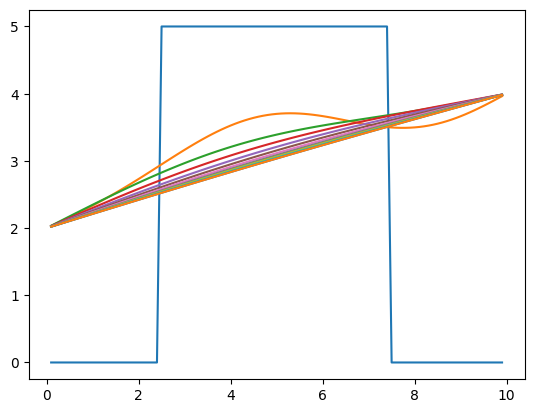

In [118]:
x = np.linspace(h, L-h, p-2)
for i in range(0, int(solution.shape[1]),600):
    plt.plot(x, solution[:,i])
plt.plot(x, solution[:,-1])


In [110]:
sol = heatequation((0,20),u0,0.01,b=b)
timespan = sol[0]
solution_CN = sol[1]
solution_CN.shape #returns (Nx, Nt)

(99, 2002)

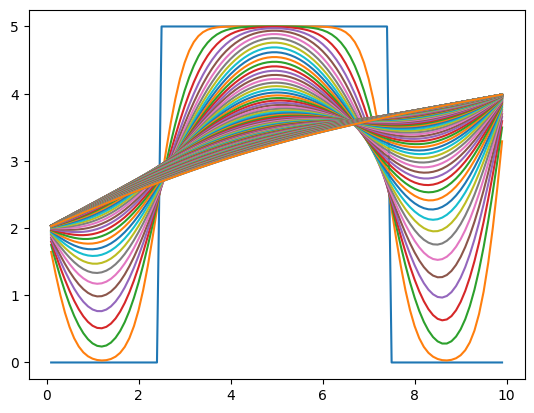

In [97]:
x = np.linspace(h, L-h, p-2)
for i in range(0, int(solution_CN.shape[1]),20):
    plt.plot(x, solution_CN[:,i])
plt.plot(x, solution_CN[:,-1])

We move on to 2D, solving heat conduction on a plate. 

Governing equation: $\frac{\partial u}{\partial t} = \kappa(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2})$

Using uniform mesh sizes $h$ in a Cartesian grid, we first proceed with a uniform rectangular domain with length $L$ and height $H$.

Denote index $i, j$ subscript for steps in space, $\delta$ superscript for steps in time.

$\frac{\partial u}{\partial t} \approx \frac{1}{\Delta t}(u_{i,j} ^{(\delta + 1)}- u_{i,j} ^{(\delta)})$ is the forward difference in time.

$\frac{\partial^2 u}{\partial x^2} \approx \frac{1}{h^2}(u_{i+1,j} ^{(\delta)} + u_{i-1,j} ^{(\delta)} + u_{i,j+1} ^{(\delta)} + u_{i,j-1} ^{(\delta)} - 4u_{i,j} ^{(\delta)})$ 

is the second order central difference in x and y, using a five-point stencil.

In [156]:
def heatequation2D(time_span, u0, dt, points_interior, dims, b):
    t_init, t_end = time_span
    px, py = points_interior
    Lx, Ly = dims
    hx, hy = (Lx/(px+1),Ly/(py+1))

    interior = px*py
    
    t = np.arange(t_init, t_end + dt, dt)
    interval = len(t)

    u0 = np.atleast_1d(u0).astype(float)

    u = np.zeros((interior,interval), dtype = float)
    u[:,0] = u0

    if b == 0:
        b = np.zeros(interior)
    else: b = b.astype(float)
    
    #Define the 1D Laplacian in x and y
    Kx = sparse.diags([1,-2,1], [-1,0,1], shape = (px,px))
    Ky = sparse.diags([1,-2,1], [-1,0,1], shape = (py,py))

    Ix = sparse.identity(px)
    Iy = sparse.identity(py)

    #Define the 2D discrete Laplacian using the Kronecker product:
    IyKx = sparse.kron(Iy, Kx) 
    KyIx = sparse.kron(Ky, Ix)

    L = IyKx + KyIx

    I = sparse.identity(interior)

    rx, ry = (kappa * dt / hx**2, kappa * dt / hy**2)

    #Applying the Crank-Nicolson scheme.

    post =  I - 0.5*(rx*IyKx + ry*KyIx)
    pre =   I + 0.5*(rx*IyKx + ry*KyIx)

    solver = sparse.linalg.splu(post.tocsc())

    for i in range(interval - 1):
        rhs = pre @ u[:,i] + (rx + ry)*b 
        u[:,i+1] = solver.solve(rhs)
        

    return t, u

In [189]:
#Define initial conditions
pxpy = (199, 199)
size = (20, 20)
u0_2d = np.zeros(pxpy) #set default clean slate
u0_2d[pxpy[0]//2, pxpy[1]//2] = 10
u0_2d[pxpy[0]//4, pxpy[1]//4] = 5
u0_2d[3*pxpy[0]//4, 3*pxpy[1]//4] = 5
u0_2d[pxpy[0]//4, 3*pxpy[1]//4] = 5
u0_2d[3*pxpy[0]//4, pxpy[1]//4] = 5
u0_2d[100, 25] = 5
u0_2d[25, 100] = 5
u0_2d[100, 175] = 5
u0_2d[175, 100] = 5
#The initial condition must be flat to input into the function.
u0_flat = u0_2d.ravel()

In [190]:
time, sol_flat = heatequation2D((0,10), u0_flat, 0.01, pxpy, size, b = 0)

In [196]:
time.shape

(1001,)

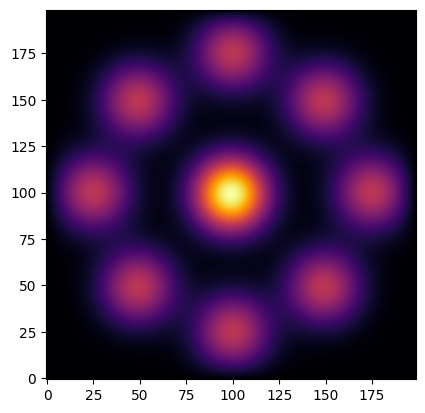

In [199]:
#indeed, any representation of the grid point values are all flattened 
#before being computed on, and must be restored for plotting.
sol_2d = sol_flat[:, 200].reshape(pxpy)
plt.clf()
plt.imshow(sol_2d, origin='lower', cmap = 'inferno')
plt.pause(0.01)
